# Preparando o ambiente

In [283]:
# Apontando para pasta geral do projeto
import os,sys
FOLDER = sys.path[0][:-20]

# Importando libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import distance

# Análises

* Há alguma diferença de movimentação entre os meses?
    ```
    - as tendências de uso
    - se há sazonalidade
    ```
* Qual o impacto das estações  do ano sobre o uso das bicicletas?
    ```
    - quando aumenta o uso das bicicletas, em quais meses cai e quando aumenta a demanda do serviço?
    ```
* Há diferenças de uso das bicicletas entre os dias da semana?
    ```
    - são mais utilizadas em dias de semana ou finais de semana?
    ```
* Quais são as rotas mais utilizadas?
    ```
    - quais estações apresentam maiores demandas?
    diferenças entre os dias úteis e finais de semana.
    ```
* Qual a duração média das viagens e a localização das estações?

* Como eventos e feriados impactam o uso das bicicletas?

* Proporção de usuários do serviço de compartilhamento de bicicletas casuais em relação aos usuários por assinatura. 

* Quais são as estações menos utilizadas?

* Qual é a proporção de bicicletas elétricas, docked e clássica?
    ```
    - A disponibilidade de bicicletas elétricas causa algum impacto na demanda?
    ```

# Importando dados

In [288]:
def import_tripdatabase():
    files_path = [f'{FOLDER}/base_de_dados/{path}' for path in os.listdir(f'{FOLDER}/base_de_dados') if '.parquet' in path]
    tripdatabase = pd.DataFrame()
    
    for file in files_path:
        tripdatabase_ = pd.read_parquet(file)
        tripdatabase = pd.concat([tripdatabase,tripdatabase_],ignore_index=True)

    # Ajustando dados vazios
    tripdatabase[['start_station_name','end_station_name']] = tripdatabase[['start_station_name','end_station_name']].fillna('-')
    # Ajustando colunas que não são string
    tripdatabase[['start_station_id','end_station_id']] = tripdatabase[['start_station_id','end_station_id']].fillna(-1).astype(int)
    tripdatabase[['start_lat','start_lng','end_lat','end_lng']] = tripdatabase[['start_lat','start_lng','end_lat','end_lng']].fillna(-1).astype(float)
    tripdatabase[['rideable_type','member_casual']] = tripdatabase[['rideable_type','member_casual']].astype('category')
    tripdatabase[['started_at','ended_at']] = tripdatabase[['started_at','ended_at']].astype(np.datetime64)
    
    # Renomeando colunas (passando para caixa alta)
    cols_dict = {col:col.upper() for col in tripdatabase.columns}
    tripdatabase = tripdatabase.rename(cols_dict,axis=1)
    
    return tripdatabase

In [289]:
tripdatabase = import_tripdatabase()

# Visão geral

In [214]:
print(tripdatabase.dtypes)
tripdatabase.head()

RIDE_ID                       object
RIDEABLE_TYPE               category
STARTED_AT            datetime64[ns]
ENDED_AT              datetime64[ns]
START_STATION_NAME            object
START_STATION_ID               int32
END_STATION_NAME              object
END_STATION_ID                 int32
START_LAT                    float64
START_LNG                    float64
END_LAT                      float64
END_LNG                      float64
MEMBER_CASUAL               category
dtype: object


,RIDE_ID,RIDEABLE_TYPE,STARTED_AT,ENDED_AT,START_STATION_NAME,START_STATION_ID,END_STATION_NAME,END_STATION_ID,START_LAT,START_LNG,END_LAT,END_LNG,MEMBER_CASUAL
0,DD15685B4DF313D3,classic_bike,2022-03-15 18:00:08,2022-03-15 18:17:02,Convention Center / 7th & M St NW,31223,4th St & G St SW,31666,38.905737,-77.022270,38.881123,-77.017658,member
1,0E4FE31A025C2769,classic_bike,2022-03-20 18:19:43,2022-03-20 18:25:28,1st & D St SE,31643,Eastern Market Metro / Pennsylvania Ave & 8th ...,31613,38.884916,-77.005965,38.884095,-76.995234,member
2,BC0E187D127FB5BB,classic_bike,2022-03-16 12:44:09,2022-03-16 12:48:00,6th & H St NE,31615,1st & K St NE,31662,38.899972,-76.998347,38.902386,-77.005649,member
3,468D0F03E6B55135,electric_bike,2022-03-15 14:12:54,2022-03-15 14:17:44,N Lynn St & Fairfax Dr,31917,Wilson Blvd & N Oak St,31939,38.893740,-77.070881,38.895068,-77.073860,member
4,1785DDDC5AF69E4D,classic_bike,2022-03-18 16:34:18,2022-03-18 17:27:02,16th & Irving St NW,31122,Eastern Market / 7th & North Carolina Ave SE,31610,38.928893,-77.036250,38.886952,-76.996806,member


# Colunas adicionais

In [215]:
# Mês da viagem
tripdatabase['NO_AM'] = tripdatabase.STARTED_AT.dt.strftime('%Y%m')

# Duração em dias, horas e minutos
tripdatabase['DURATION_D'] = (tripdatabase.ENDED_AT - tripdatabase.STARTED_AT)/np.timedelta64(1,'D')
tripdatabase['DURATION_H'] = (tripdatabase.ENDED_AT - tripdatabase.STARTED_AT)/np.timedelta64(1,'h')
tripdatabase['DURATION_MIN'] = (tripdatabase.ENDED_AT - tripdatabase.STARTED_AT)/np.timedelta64(1,'m')

# Distância das viagens
tripdatabase['DISTANCE'] = tripdatabase.apply(lambda df: distance((df.START_LAT,df.START_LNG),(df.END_LAT,df.END_LNG)).km if df.END_LAT != -1 else float('nan'),axis=1)


In [216]:
# Salvando dados para evitar repetir processamentos demorados
tripdatabase.to_parquet(f'{FOLDER}/base_de_dados/agregada/capitalbikeshare-tripdata-agg.parquet')

# Análise exploratória

In [217]:
sns.set_style('darkgrid')
sns.set_context('paper')

## Tipos de bicicleta

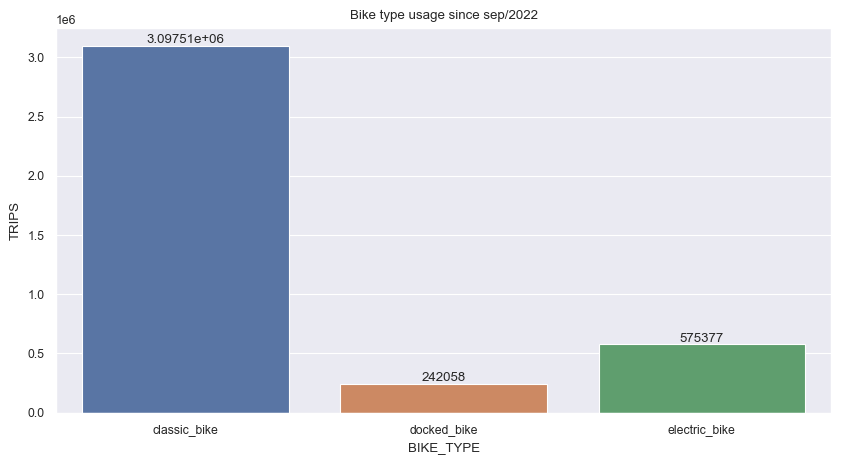

In [225]:
# Utilização de bicicletas desde set/2022
df_bike = (
    tripdatabase
    .groupby('RIDEABLE_TYPE',as_index=False)
    .agg(TRIPS = ('RIDE_ID','count'))
    .rename({'RIDEABLE_TYPE':'BIKE_TYPE'},axis=1)
)
plt.figure(figsize=(10,5))
graph = sns.barplot(df_bike,x='BIKE_TYPE',y='TRIPS')
graph.bar_label(graph.containers[0])
plt.title('Bike type usage since sep/2022')
plt.show()

# Predominância do tipo clássico

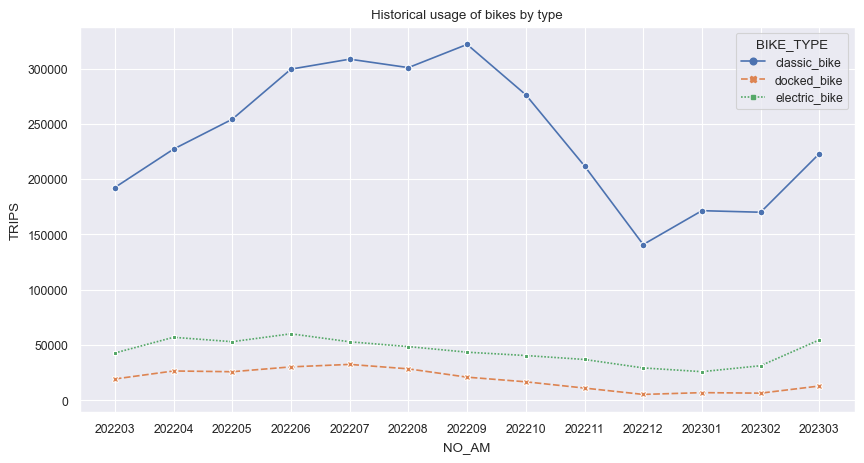

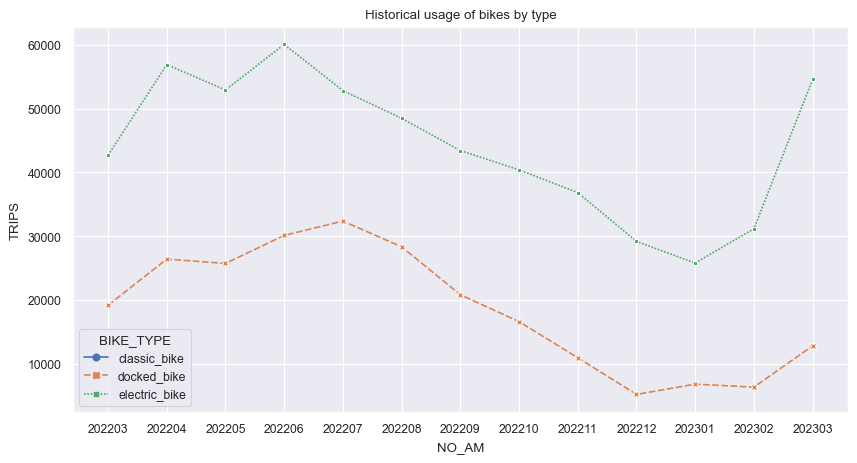

In [219]:
# Embora o tipo clássico seja o mais utilizado de forma geral,
# será que isso é verdade ao longo dos meses?
df_bike = (
    tripdatabase
    .groupby(['NO_AM','RIDEABLE_TYPE'],as_index=False)
    .agg(TRIPS = ('RIDE_ID','count'))
    .rename({'RIDEABLE_TYPE':'BIKE_TYPE'},axis=1)
)
# Todos os tipos
plt.figure(figsize=(10,5))
sns.lineplot(df_bike,x='NO_AM',y='TRIPS',hue='BIKE_TYPE',style='BIKE_TYPE',markers=True)
plt.title('Historical usage of bikes by type')
plt.show()

# Sem o tipo clássico
plt.figure(figsize=(10,5))
graph = sns.lineplot(df_bike[df_bike.BIKE_TYPE != 'classic_bike'],x='NO_AM',y='TRIPS',
             hue='BIKE_TYPE',style='BIKE_TYPE',markers=True)
plt.title('Historical usage of bikes by type')
plt.show()

## O uso de bicicletas clássicas é predominantes em todos os meses

## É possível observar quedas no uso das bicicletas de modo geral, 
## com leve retomada de crescimento a partir de dez/2022

## Vale ressaltar que enquanto a utilização de bicicletas elétricas diminuiu de dez/22 a jan/23,
## as demais começam a ter um leve aumento no número de utilizações. 
## Entretando, a utilização de bicicletas elétricas demonstra tendência de crescimento 
## muito maior do que as demais a partir de jan/23 

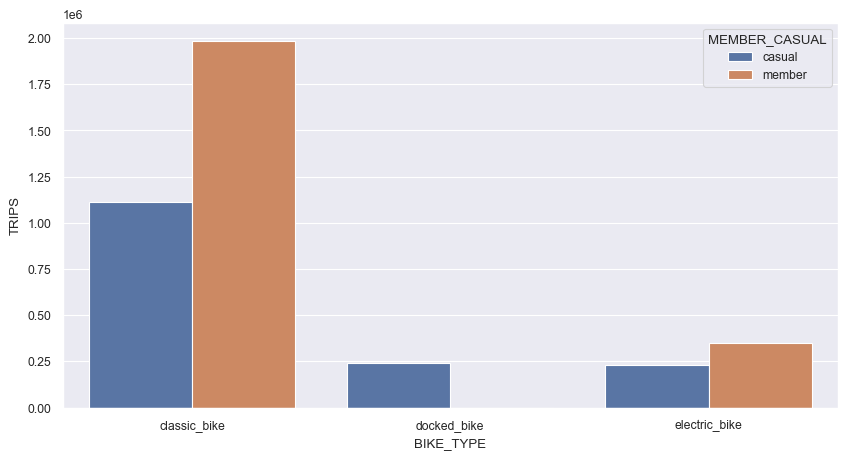

In [230]:
# Tipos de bicicletas mais utilizadas por cada tipo de membro
df_bike_member = (
    tripdatabase
    .groupby(['RIDEABLE_TYPE','MEMBER_CASUAL'],as_index=False)['RIDE_ID']
    .count()
    .rename({'RIDEABLE_TYPE':'BIKE_TYPE','RIDE_ID':'TRIPS'},axis=1)
)
plt.figure(figsize=(10,5))
sns.barplot(df_bike_member,x='BIKE_TYPE',y='TRIPS',hue='MEMBER_CASUAL');
plt.show()
# É possível retirar duas informações relevantes a partir deste gráfico:
## 1 - A "docked_bike" é uma classificação de bicicletas que separa os membros dos consumidores casuais
## Uma fonte explicando como a capital bikeshare define esse dado não foi encontrada, portanto, essa informação ainda é inconclusiva
## 2 - A quantidade de viagens realizadas por membros supera as viagens casuais

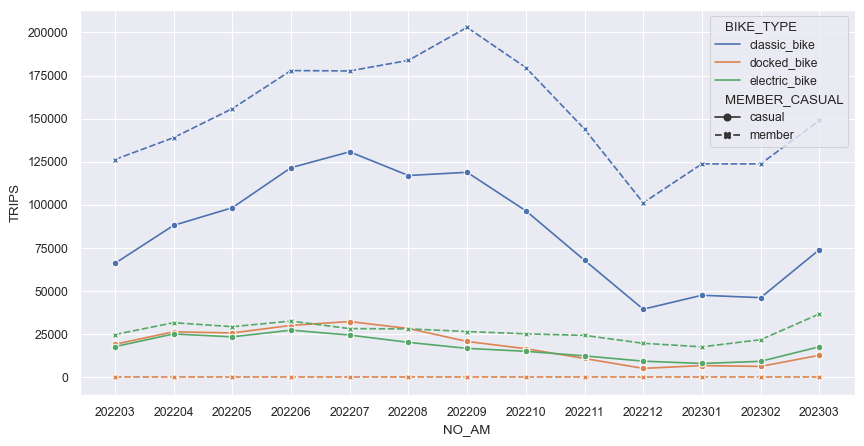

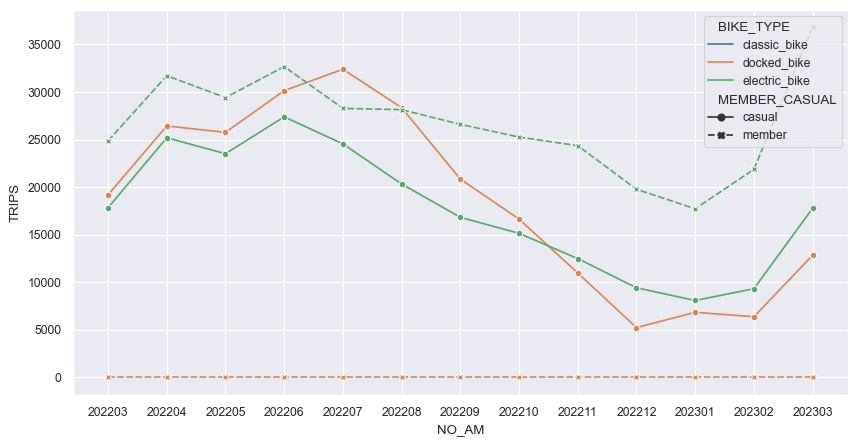

In [235]:
df_bike_member = (
    tripdatabase
    .groupby(['NO_AM','RIDEABLE_TYPE','MEMBER_CASUAL'],as_index=False)['RIDE_ID']
    .count()
    .rename({'RIDEABLE_TYPE':'BIKE_TYPE','RIDE_ID':'TRIPS'},axis=1)
)
plt.figure(figsize=(10,5))
sns.lineplot(df_bike_member,x='NO_AM',y='TRIPS',hue='BIKE_TYPE',style='MEMBER_CASUAL',markers=True)
plt.show()

plt.figure(figsize=(10,5))
sns.lineplot(df_bike_member[df_bike_member.BIKE_TYPE != 'classic_bike'],x='NO_AM',y='TRIPS',hue='BIKE_TYPE',style='MEMBER_CASUAL',markers=True)
plt.show()

# Os perfis históricos do uso de bicicleta por tipo de membro é comum para a clássica e elétrica,
# tendo apenas a docked diferente, que parece sofrer queda de uso de forma retardada em relação às demais

## Estações

In [239]:
# Criando dimensão para saber o nome das estações.
# Sabendo que o nome das estações muda ao longo do tempo, o nome mais recente para cada ID será coletado
dm_estacao = pd.concat([
    tripdatabase.rename({'START_STATION_ID':'STATION_ID','START_STATION_NAME':'STATION_NAME'},axis=1)[['STATION_ID','STATION_NAME','NO_AM']],
    tripdatabase.rename({'END_STATION_ID':'STATION_ID','END_STATION_NAME':'STATION_NAME'},axis=1)[['STATION_ID','STATION_NAME','NO_AM']]
])
dm_estacao = (
    dm_estacao
    .sort_values('NO_AM',ascending=False)
    .groupby('STATION_ID',as_index=False)['STATION_NAME']
    .first()
)

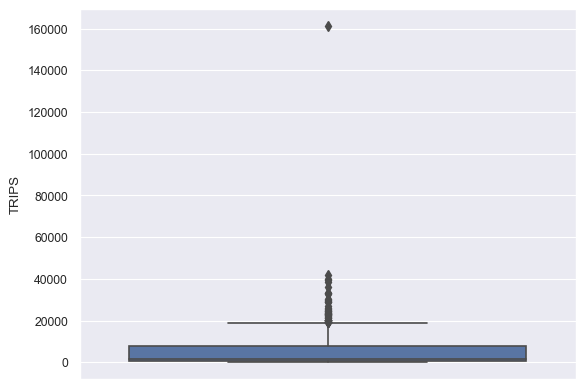

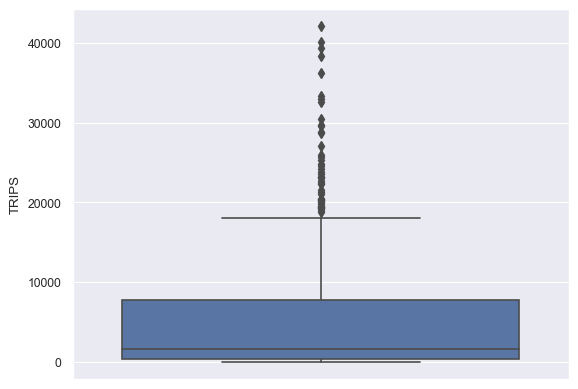

Existem 181 estações acima do percentil 75, representando 72.26% do total de viagens


In [271]:
# Top estações mais utilizadas - Início da viagem
df_estacao = (
    tripdatabase.sort_values('NO_AM',ascending=False)
    .groupby('START_STATION_ID',as_index=False)
    .agg(STATION_NAME = ('START_STATION_NAME','first'),TRIPS = ('RIDE_ID','count'))
    .sort_values('TRIPS')
)

sns.boxplot(df_estacao,y='TRIPS')
plt.show()
# Viagens sem ponto específico de partida se deslocam muito do comportamento padrão

sns.boxplot(df_estacao[df_estacao.START_STATION_ID != -1],y='TRIPS')
plt.show()

# Muitos locais se destacam, contudo, não necessariamente são outliers, mas sim regiões com alto fluxo de pessoas
p75 = df_estacao.TRIPS.quantile(.75)
estacoes_acima_p75 = df_estacao[(df_estacao.TRIPS > p75) & (df_estacao.START_STATION_ID != -1)].START_STATION_ID.nunique()
pc_viagens_acima_p75 = df_estacao[(df_estacao.TRIPS > p75) & (df_estacao.START_STATION_ID != -1)].TRIPS.sum()/df_estacao.TRIPS.sum()
print(f'Existem {estacoes_acima_p75} estações acima do percentil 75, representando {pc_viagens_acima_p75*100:.2f}% do total de viagens')
# 72% das viagens são provenientes de 25% das estações, seguindo de certa forma o princípio de pareto

In [272]:
# TOP 10 mais utilizadas
top10_start = df_estacao.tail(10)

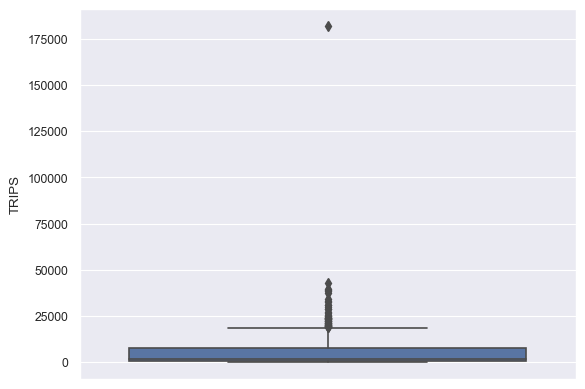

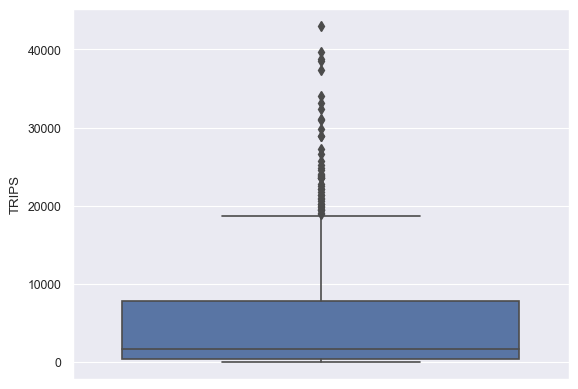

Existem 181 estações acima do percentil 75, representando 72.86% do total de viagens


In [273]:
# Top estações mais utilizadas - InícioFim da viagem
df_estacao = (
    tripdatabase.sort_values('NO_AM',ascending=False)
    .groupby('END_STATION_ID',as_index=False)
    .agg(STATION_NAME = ('END_STATION_NAME','first'),TRIPS = ('RIDE_ID','count'))
    .sort_values('TRIPS')
)

sns.boxplot(df_estacao,y='TRIPS')
plt.show()
# Viagens sem ponto específico de partida se deslocam muito do comportamento padrão

sns.boxplot(df_estacao[df_estacao.END_STATION_ID != -1],y='TRIPS')
plt.show()

# Muitos locais se destacam, contudo, não necessariamente são outliers, mas sim regiões com alto fluxo de pessoas
p75 = df_estacao.TRIPS.quantile(.75)
estacoes_acima_p75 = df_estacao[(df_estacao.TRIPS > p75) & (df_estacao.END_STATION_ID != -1)].END_STATION_ID.nunique()
pc_viagens_acima_p75 = df_estacao[(df_estacao.TRIPS > p75) & (df_estacao.END_STATION_ID != -1)].TRIPS.sum()/df_estacao.TRIPS.sum()
print(f'Existem {estacoes_acima_p75} estações acima do percentil 75, representando {pc_viagens_acima_p75*100:.2f}% do total de viagens')
# 73% das viagens são provenientes de 25% das estações, também seguindo de certa forma o princípio de pareto

In [274]:
# TOP 10 mais utilizadas
top10_end = df_estacao.tail(10)

In [282]:
top10_start.merge(top10_end,on='STATION_NAME',how='outer',suffixes=('_START','_END')).sort_values('TRIPS_START',ascending=False)

,START_STATION_ID,STATION_NAME,TRIPS_START,END_STATION_ID,TRIPS_END
9,-1.0,-,161181.0,-1.0,181850.0
8,31623.0,Columbus Circle / Union Station,42067.0,31623.0,42978.0
7,31229.0,New Hampshire Ave & T St NW,40058.0,31229.0,39720.0
6,31258.0,Lincoln Memorial,39320.0,31258.0,38831.0
5,31201.0,15th & P St NW,38352.0,31201.0,38558.0
4,31247.0,Jefferson Dr & 14th St SW,36175.0,31247.0,37390.0
3,31248.0,Smithsonian-National Mall / Jefferson Dr & 12t...,33267.0,31248.0,34086.0
2,31603.0,1st & M St NE,32996.0,31603.0,33197.0
1,31288.0,4th St & Madison Dr NW,32623.0,31288.0,32324.0
0,31600.0,5th & K St NW,30497.0,NaN,NaN
